# Fashion MNIST Classification with PyTorch

## Tasks and objectives

In this notebook I will use PyTorch to build a convolutional neural network to classify the images from the MNIST fashion dataset.  

The performance of two different model architectures will be compared.


## Importing libraries and loading data

In [1]:
import torch
from collections import Counter
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(0)
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import time

IMAGE_SIZE = 16
# Create a transform to resize image and convert to tensor
composed_trafo = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

# Create Train and Test/Validation Dataset from MNIST and apply composed transformation
train_dataset = dsets.FashionMNIST(root='.fashion/data', train=True, download=True, transform=composed_trafo)
validation_dataset = dsets.FashionMNIST(root='.fashion/data', train=False, download=True, transform=composed_trafo)

## Exploring the data

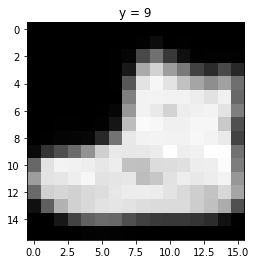

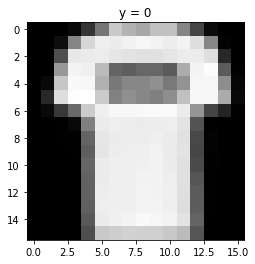

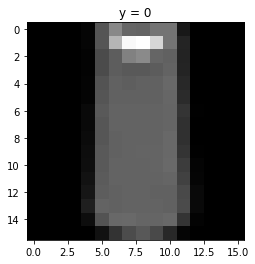

label: 9  - occurance 6000
label: 0  - occurance 6000
label: 0  - occurance 6000
label: 3  - occurance 6000
label: 0  - occurance 6000
label: 2  - occurance 6000
label: 7  - occurance 6000
label: 2  - occurance 6000
label: 5  - occurance 6000
label: 5  - occurance 6000


In [2]:
def show_image(data_sample):
    plt.figure()
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))
    plt.show()
    
for i in range(3):
    show_image(train_dataset[i])

labels = [train_dataset[i][1] for i in range(len(train_dataset))]
occurance = [labels.count(i) for i in np.unique(labels)]
for label,occurance in zip(labels,occurance):
    print('label: {}'.format(label) + '  - occurance {}'.format(occurance) )

All the training labels are equally often present in the training set. Accuracy is thus a good performance measure.

## Model set up

In [3]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x



In [4]:
class CNN_batch(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x=self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x=self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.bn_fc1(x)
        return x

In [5]:
def train_model(model,train_loader,validation_loader,optimizer,n_epochs=4):
    #global variable 
    N_test=len(validation_dataset)
    accuracy_list=[]
    cost_list=[]
    for epoch in range(n_epochs):
        cost=0
        for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            cost+=loss.item()

        correct=0
        model.eval()
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        cost_list.append(cost)
     
    return accuracy_list, cost_list

## A.1) Defining the CNN baseline model

In [6]:
# Create the model object using CNN class
model = CNN(out_1=16, out_2=32,number_of_classes=10)

epochs = 10
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

## A.2) Training the CNN baseline model

In [7]:
accuracy_list_normal, cost_list_normal=train_model(model=model,n_epochs=epochs,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

## B.1) Defining the CNN batch normalization model

In [8]:
model_batch=CNN_batch(out_1=16, out_2=32,number_of_classes=10)
optimizer = torch.optim.Adam(model_batch.parameters(), lr = learning_rate)

## B.2) Training the CNN batch normalization model

In [9]:
accuracy_list_batch, cost_list_batch=train_model(model=model_batch,n_epochs=epochs,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

## Model evaluation

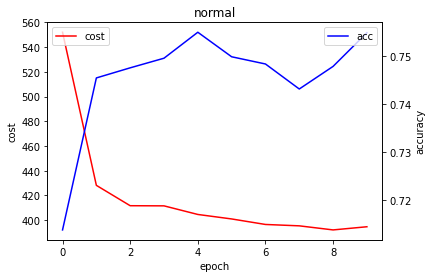

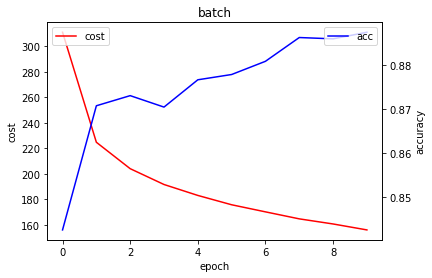

In [18]:
cost = [cost_list_normal,cost_list_batch]
acc = [accuracy_list_normal,accuracy_list_batch]
model = ['normal', 'batch']
for cost_list,acc_list,model_name in zip(cost,acc,model):
    
    fig, ax1 = plt.subplots()
    ax1.plot(cost_list, color='r',linestyle='-',label='cost')
    ax1.set_ylabel('cost')
    ax1.set_xlabel('epoch')
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx() 
    ax2.plot(acc_list, color='b',label='acc')
    ax2.set_ylabel('accuracy') 
    ax2.legend(loc='upper right')

    plt.title(model_name)
    plt.show()

## Remarks

The batch normalized cnn model performs better than the baseline cnn model. After 10 training epochs the batch model achives an accuracy of more than 0.88. The baseline model only reaches an accuracy of  